<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Formulas" data-toc-modified-id="Formulas-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Formulas</a></span></li><li><span><a href="#Function-definitions" data-toc-modified-id="Function-definitions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function definitions</a></span><ul class="toc-item"><li><span><a href="#Main-functionality-(Python)" data-toc-modified-id="Main-functionality-(Python)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Main functionality (Python)</a></span></li><li><span><a href="#Load/save" data-toc-modified-id="Load/save-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Load/save</a></span></li><li><span><a href="#Misc" data-toc-modified-id="Misc-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Misc</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Main-functionality-Cython" data-toc-modified-id="Main-functionality-Cython-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Main functionality Cython</a></span><ul class="toc-item"><li><span><a href="#Quick-check" data-toc-modified-id="Quick-check-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Quick check</a></span></li></ul></li><li><span><a href="#Sanity-check" data-toc-modified-id="Sanity-check-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Sanity check</a></span><ul class="toc-item"><li><span><a href="#Gaussian-probability-distributions" data-toc-modified-id="Gaussian-probability-distributions-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Gaussian probability distributions</a></span><ul class="toc-item"><li><span><a href="#Plots" data-toc-modified-id="Plots-2.6.1.1"><span class="toc-item-num">2.6.1.1&nbsp;&nbsp;</span>Plots</a></span></li><li><span><a href="#Checks" data-toc-modified-id="Checks-2.6.1.2"><span class="toc-item-num">2.6.1.2&nbsp;&nbsp;</span>Checks</a></span></li><li><span><a href="#Entropy" data-toc-modified-id="Entropy-2.6.1.3"><span class="toc-item-num">2.6.1.3&nbsp;&nbsp;</span>Entropy</a></span></li><li><span><a href="#Mutual-information" data-toc-modified-id="Mutual-information-2.6.1.4"><span class="toc-item-num">2.6.1.4&nbsp;&nbsp;</span>Mutual information</a></span></li></ul></li><li><span><a href="#Coin-flip" data-toc-modified-id="Coin-flip-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Coin flip</a></span></li></ul></li></ul></li><li><span><a href="#Calculation" data-toc-modified-id="Calculation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Calculation</a></span><ul class="toc-item"><li><span><a href="#Feature-preparation" data-toc-modified-id="Feature-preparation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Feature preparation</a></span></li><li><span><a href="#Validation" data-toc-modified-id="Validation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Validation</a></span></li><li><span><a href="#Mutual-information" data-toc-modified-id="Mutual-information-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Mutual information</a></span><ul class="toc-item"><li><span><a href="#Single-features-only-(a)" data-toc-modified-id="Single-features-only-(a)-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Single features only (a)</a></span></li><li><span><a href="#Backbone-as-2D-feature-(b)" data-toc-modified-id="Backbone-as-2D-feature-(b)-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Backbone as 2D feature (b)</a></span></li><li><span><a href="#All-$\chi$-angles-(c)" data-toc-modified-id="All-$\chi$-angles-(c)-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>All $\chi$-angles (c)</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Plots</a></span></li></ul></li><li><span><a href="#Projection" data-toc-modified-id="Projection-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Projection</a></span></li><li><span><a href="#Plots" data-toc-modified-id="Plots-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Plots</a></span></li></ul></li></ul></div>

# Mutual information

Notebook for interactive mutual information analysis. Core functionality accelerated with Cython. Example usage shown for protein dihedral angle distributions. Functionality should be reliable (see checks under function definition section). Usage examples may miss clarity and should be reviewed.

In [1]:
import os
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj   # Only for protein structure inspection
import networkx
import nglview  # Only for protein structure inspection
import numpy as np
import scipy.stats
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.metrics import mutual_info_score
from tqdm.notebook import tqdm
from typing import Any

%reload_ext cython

/home/janjoswig/.pyenv/versions/mambaforge-23.11.0-0/envs/nmi/lib/python3.10/site-packages/nglview/__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Set matplotlib parameters
mpl.rcParams["figure.dpi"] = 120

# Limit number of used CPU cores
os.environ["OMP_NUM_THREADS"] = "8"
!echo ${OMP_NUM_THREADS}

8


## Formulas

Shannon entropy:

$$H(x) = \sum_{i} p(x_i) \log p(x_i)$$

Mutual information:
    
$$M(x, y) = \sum_{i}\sum_{j} p_{xy}(x_i, y_j) \log \frac{p_{xy}(x_i, y_j)}{p_{x}(x_i)p_{y}(y_j)}$$

Normalized mutual information:

$$\tilde{M} = \frac{M(x, y)}{\min(H(x), (H(y))}$$

## Function definitions

### Main functionality (Python)

In [3]:
def p(x: np.ndarray, **hist_kwargs: Any) -> np.ndarray:
    """Probability mass function for discrete variable

    Args:
        x: Discrete samples of variable *x* (`numpy.ndarray` of shape (*n*,))

    Keyword args:
        hist_kwargs: Passed on to `numpy.histogram`

    Returns:
        * Discrete probability mass function of *x*
        * Bin edges of the used histogram
        * Midpoints of the bins
    """

    histogram_kwargs = {
        "range": (-np.pi, np.pi),
        "bins": 72,
        "weights": np.ones_like(x) / x.shape[0]
    }

    histogram_kwargs.update(**hist_kwargs)

    px, ex = np.histogram(x, **histogram_kwargs)
    emids = (ex[:-1] + ex[1:]) / 2

    return np.array(px, order="c", dtype=np.float64), ex, emids

In [4]:
def p_joint(x: np.ndarray, y: np.ndarray, **hist_kwargs: Any) -> np.ndarray:
    """Joint probability mass function for two discrete variables

    Args:
        x: Discrete samples of variable *x* (`numpy.ndarray` of shape (*n*,))
        y: Discrete samples of variable *y* (`numpy.ndarray` of shape (*n*,))

    Keyword args:
        hist_kwargs: Passed on to `numpy.histogram`

    Returns:
        * 2D discrete probability mass function of *x* and *y*
        * Bin edges of the used histogram for *x*
        * Bin edges of the used histogram for *y*
    """

    histogram_kwargs = {
        "range": [(-np.pi, np.pi), (-np.pi, np.pi)],
        "bins": [72, 72],
        "weights": np.ones_like(x) / x.shape[0]
    }

    histogram_kwargs.update(**hist_kwargs)

    pxy, ex, ey = np.histogram2d(x, y, **histogram_kwargs)

    return np.array(pxy, order="c", dtype=np.float64), ex, ey

In [5]:
def shannon_entropy(distribution: np.ndarray) -> float:
    """Compute Shannon entropy

    Args:
        distribution: Probability mass function

    Returns:
        Shannon entropy of the distribution
    """

    nonzero = np.nonzero(distribution)
    return -(distribution[nonzero] * np.log(distribution[nonzero])).sum()

In [6]:
def mutual_information(marginal_x, marginal_y, joint_distribution, norm=True):
    """Compute mutual information

    Args:
        marginal_x, marginal_y: Probability mass function.
        joint_distribution: Joint probability mass function of the marginals.

    Keyword args:
        norm: Normalise result using Shannon entropy of the marginals.
    """

    MX, MY = np.meshgrid(marginal_y, marginal_x)
    MXY = MX * MY
    nonzero = np.nonzero(MXY * joint_distribution)

    mi = np.sum(joint_distribution[nonzero] * np.log(np.true_divide(joint_distribution[nonzero], MXY[nonzero])))

    if norm:
        mi = np.true_divide(mi, min(shannon_entropy(marginal_x), shannon_entropy(marginal_y)))

    return mi

### Load/save

In [ ]:
def nmi_matrix_to_graph(matrix, feature_list_ids):
    """Convert matrix to :class:`networkx.MultiGraph`

    Args:
        matrix: Square matrix to be converted.
        feature_list_ids: List of features to be used in the graph.

    Returns:
        Graph
    """

    category_map = {
        ("bb", "bb"): 0,
        ("phi", "phi"): 0,
        ("psi", "psi"): 0,
        ("phi", "psi"): 0,
        ("psi", "phi"): 0,
        ("bb", "chi"): 1,
        ("chi", "bb"): 1,
        ("phi", "chi"): 0,
        ("psi", "chi"): 0,
        ("chi", "phi"): 0,
        ("chi", "psi"): 0,
        ("chi", "chi"): 2,
    }

    def get_category(ka, kb):
        ka = re.sub(r'\d+', '', ka)
        kb = re.sub(r'\d+', '', kb)

        return category_map.get((ka, kb), 3)

    G = networkx.MultiGraph()

    for i in range(matrix.shape[0]):
        for j in range(i + 1, matrix.shape[1]):

            nmi = matrix[i, j]

            if not (nmi > 0.):
                continue

            feature_i_id = feature_list_ids[i]
            feature_j_id = feature_list_ids[j]

            feature_i, res_i = feature_i_id.split("-")
            feature_j, res_j = feature_j_id.split("-")

            G.add_edge(
                res_i, res_j,
                a=feature_i_id,
                b=feature_j_id,
                nmi=float(nmi),
                category=get_category(feature_i, feature_j)
            )

    return G

In [ ]:
def graph_to_nmi_matrix(G, feature_list_ids):
    """Convert :class:`networkx.Graph` to square matrix"""

    n_features = len(feature_list_ids)
    nmi_matrix = np.eye(n_features, dtype=np.float64)

    for res_a, res_b, data in G.edges(data=True):
        i = feature_list_ids.index(data["a"])
        j = feature_list_ids.index(data["b"])

        nmi_matrix[i, j] = data["nmi"]

    return nmi_matrix

### Misc

In [9]:
def prepare_feature_list(features, feature_definitions, feature_ids=None, residue_range=(256, 381), offset=0, feature_id_template="{ftype}-{resid}"):
    """Prepare list of features and ids to be used for nmi computation

    Args:
        features: 2D-array of features with shape (#nframes, #nfeatures)
        feature_definitions: List of tuples, where each tuple contains:
            - List of feature names (e.g. `["phi", "psi"]`)
            - Unique identifier for the feature (e.g. `"backbone"`)

    Keyword args:
        feature_ids: List of feature IDs to be used for matching
        residue_range: Range of residues (biological numbering) to consider
        offset: Offset to apply to residue numbering
        feature_id_template: Template for feature IDs, i.e. a string with optional
            placeholders `{ftype}` for feature type and `{resid}` for residue ID

    Returns:
        List of prepared feature arrays and their corresponding IDs
    """

    feature_list = []
    feature_list_ids = []

    if feature_ids is None:
        feature_ids = [f"f{i}" for i in range(features.shape[1])]

    for bioid in tqdm(range(*residue_range)):
        resid = bioid - offset

        for angle_names, list_id in feature_definitions:
            tmp_feature = []
            for name in angle_names:
                try:
                    feature_index = feature_ids.index(feature_id_template.format(ftype=name, resid=resid))
                    tmp_feature.append(features[:, feature_index])
                except ValueError:
                    break
            else:
                feature_list.append(
                    np.array(np.vstack(tmp_feature).T, ndmin=2, order="c", dtype=np.float64)
                )
                feature_list_ids.append(f"{list_id}-{resid}")

    return feature_list, feature_list_ids

### Plotting

In [10]:
def format_id(i):
    """String formatting of feature ids for plotting"""

    i = i.replace("_", " ")
    i = i.replace("phi", "$\phi$")
    i = i.replace("psi", "$\psi$")
    i = i.replace("chi1", "$\chi_1$")
    i = i.replace("chi2", "$\chi_2$")
    i = i.replace("chi3", "$\chi_3$")
    i = i.replace("chi4", "$\chi_4$")

    return i

### Main functionality Cython

In [11]:
%%cython -a --compile-args=-fopenmp --link-args=-fopenmp

# distutils: define_macros=NPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION
# cython: wraparound = False
# cython: boundscheck = False
# cython: cdivision = True

import pathlib

import numpy as np
cimport numpy as np

from cython.operator cimport dereference as deref
from cython.parallel cimport prange
from libc.math cimport log as clog

ctypedef np.float64_t AVALUE
ctypedef np.intp_t AINDEX


cpdef inline AVALUE c_shannon_entropy(AVALUE[::1] px) nogil:
    return _c_shannon_entropy(&px[0], px.shape[0])


cdef inline AVALUE _c_shannon_entropy(AVALUE *px, AINDEX n) nogil:
    cdef AVALUE entropy = 0
    cdef AINDEX i

    for i in range(n):

        if px[i] == 0:
            continue

        entropy += px[i] * clog(px[i])

    return -entropy


cdef inline AVALUE cmin(AVALUE a, AVALUE b) nogil:
    if a > b:
        return b
    return a


cpdef AVALUE c_norm_mutual_information(
        AVALUE[::1] px, AVALUE[::1] py, AVALUE[:, ::1] pxy):

    return _c_norm_mutual_information(&px[0], px.shape[0], &py[0], py.shape[0], &pxy[0, 0])


cdef inline AVALUE _c_norm_mutual_information(
        AVALUE *px, AINDEX nx, AVALUE *py, AINDEX ny, AVALUE *pxy) nogil:

    cdef AVALUE mi = 0, pxi, pyj, pxyij, min_entropy
    cdef AINDEX i, j

    for i in range(nx):
        for j in range(ny):

            pxyij = pxy[i * ny + j]

            if pxyij == 0:
                continue

            pxi = px[i]
            pyj = py[j]

            if (pxi == 0) | (pyj == 0):
                continue

            mi += pxyij * clog(pxyij / (pxi * pyj))

    min_entropy = cmin(
        _c_shannon_entropy(px, nx),
        _c_shannon_entropy(py, ny)
        )

    return mi / min_entropy


cdef inline AINDEX find_bin(AVALUE value, AVALUE *start, AVALUE *end) nogil:
    """Find bin in which to put value

    Args:
        value: Value to sort in.
        start: Pointer to left edge.
        end: Pointer to right edge.

    Returns:
        Bin index
    """

    cdef AVALUE *lower = start
    cdef AVALUE *upper = end
    cdef AVALUE *test

    while True:
        if (upper - lower) == 1:
            return lower - start

        test = ((upper - lower) // 2) + lower

        if value < deref(test):
            upper = test
        else:
            lower = test

    return -1


cpdef AVALUE[::1] c_histogram(AVALUE[::1] x, AVALUE[::1] edges):
    """Compute histogram from 1D-buffer

    Args:
        x: 1D-Buffer representing *n* value samples.
        edges: 1D-Buffer with bin edges

    Returns:
        Memoryview with bin counts
    """

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX nb = edges.shape[0] - 1

    cdef AVALUE[::1] counts = np.zeros(nb, dtype=np.float64)

    _c_histogram(&x[0], nx, &edges[0], nb, &counts[0])

    return counts


cdef inline void _c_histogram(
        AVALUE *x, AINDEX nx,
        AVALUE *edges_start, AINDEX nb,
        AVALUE *counts) noexcept nogil:

    cdef AVALUE *edges_end = edges_start + nb

    cdef AINDEX xi
    cdef AVALUE xvalue

    for xi in range(nx):
        xvalue = x[xi]

        if (xvalue < deref(edges_start)) | (xvalue > deref(edges_end)):
            # Value out of bin range
            continue

        counts[find_bin(xvalue, edges_start, edges_end)] += 1


cpdef AVALUE[::1] c_histogramdd(AVALUE[:, ::1] x, AVALUE[::1] edges):
    """Compute histogram from 2D-buffer

    Args:
        x: 2D-Buffer representing *n* value samples in *d* dimensions.
        edges: 1D-Buffer with bin edges. Note, that the same edges are
            used for all dimensions.

    Returns:
        Memoryview with bin counts
    """

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX nd = x.shape[1]
    cdef AINDEX nb = edges.shape[0] - 1

    cdef AVALUE[::1] counts = np.zeros(<AINDEX>nb**nd, dtype=np.float64)

    _c_histogramdd(&x[0, 0], nx, nd, &edges[0], nb, &counts[0])

    return counts


cdef inline void _c_histogramdd(
        AVALUE *x, AINDEX nx, AINDEX nd,
        AVALUE *edges_start, AINDEX nb,
        AVALUE *counts) noexcept nogil:

    cdef AVALUE *edges_end = edges_start + nb

    cdef AINDEX xi, di
    cdef AVALUE xvalue

    cdef AINDEX tmp_bin

    for xi in range(nx):
        tmp_bin = 0

        for di in range(nd):

            xvalue = x[xi * nd + di]

            if (xvalue < deref(edges_start)) | (xvalue > deref(edges_end)):
                # Value out of bin range
                break

            tmp_bin = tmp_bin + find_bin(xvalue, edges_start, edges_end) * <AINDEX>nb ** (nd - 1 - di)

        else:
            counts[tmp_bin] += 1


cpdef AVALUE[:, ::1] c_histogramdd_joint(AVALUE[:, ::1] x, AVALUE[:, ::1] y, AVALUE[::1] edges):
    """Compute joint histogram from 2D-buffers

    Args:
        x: 2D-Buffer representing *n* value samples in *dx* dimensions.
        y: 2D-Buffer representing *n* value samples in *dy* dimensions (same number of values as `x`).
        edges: 1D-Buffer with bin edges. Note, that the same edges are
            used for all dimensions of `x` and `y`.

    Returns:
        2D-Memoryview with bin counts
    """

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX ndx = x.shape[1]
    cdef AINDEX ndy = y.shape[1]

    cdef AINDEX nb = edges.shape[0] - 1

    cdef AVALUE[:, ::1] counts = np.zeros((<AINDEX>nb**ndx, <AINDEX>nb**ndy), dtype=np.float64)

    _c_histogramdd_joint(&x[0, 0], nx, ndx, &y[0, 0], ndy, &edges[0], nb, &counts[0, 0])

    return counts


cdef inline void _c_histogramdd_joint(
    AVALUE *x, AINDEX nx, AINDEX ndx,
    AVALUE* y, AINDEX ndy,
    AVALUE *edges_start, AINDEX nb,
    AVALUE* counts) noexcept nogil:

    cdef AVALUE *edges_end = edges_start + nb

    cdef AINDEX xi, di
    cdef AVALUE xvalue, yvalue

    cdef AINDEX tmp_xbin
    cdef AINDEX tmp_ybin
    cdef AINDEX target_bin

    cdef AINDEX counts_xstride = nb**ndy

    for xi in prange(nx, schedule="static"):
        tmp_xbin = 0
        tmp_ybin = 0

        for di in range(ndx):

            xvalue = x[xi * ndx + di]

            if (xvalue < deref(edges_start)) | (xvalue > deref(edges_end)):
                # Value out of bin range
                break

            tmp_xbin = tmp_xbin + find_bin(xvalue, edges_start, edges_end) * <AINDEX>nb ** (ndx - 1 - di)

        else:
            for di in range(ndy):

                yvalue = y[xi * ndy + di]

                if (yvalue < deref(edges_start)) | (yvalue > deref(edges_end)):
                    # Value out of bin range
                    break

                tmp_ybin = tmp_ybin + find_bin(yvalue, edges_start, edges_end) * <AINDEX>nb ** (ndy - 1 - di)

            else:
                target_bin = tmp_xbin * counts_xstride + tmp_ybin
                counts[target_bin] = counts[target_bin] + 1


cpdef AVALUE[::1] compute_marginal_x(AVALUE[:, ::1] pxy):

    cdef AINDEX nx = pxy.shape[0]
    cdef AINDEX ny = pxy.shape[1]

    cdef AVALUE[::1] px = np.zeros(nx, dtype=np.float64)

    _compute_marginal_x(&pxy[0, 0], &px[0], nx, ny)

    return px


cpdef AVALUE[::1] compute_marginal_y(AVALUE[:, ::1] pxy):

    cdef AINDEX nx = pxy.shape[0]
    cdef AINDEX ny = pxy.shape[1]

    cdef AVALUE[::1] py = np.zeros(ny, dtype=np.float64)

    _compute_marginal_y(&pxy[0, 0], &py[0], nx, ny)

    return py


cdef inline void _compute_marginal_x(AVALUE *pxy, AVALUE *px, AINDEX nx, AINDEX ny) noexcept nogil:

    cdef AINDEX xi, yi
    cdef AVALUE marginal_sum

    for xi in prange(nx, schedule="static"):
        marginal_sum = 0

        for yi in range(ny):
            marginal_sum = marginal_sum + pxy[xi * ny + yi]

        px[xi] = marginal_sum


cdef inline void _compute_marginal_y(AVALUE *pxy, AVALUE *py, AINDEX nx, AINDEX ny) noexcept nogil:

    cdef AINDEX xi, yi
    cdef AVALUE marginal_sum

    for yi in prange(ny, schedule="static"):
        marginal_sum = 0

        for xi in range(nx):
            marginal_sum = marginal_sum + pxy[xi * ny + yi]

        py[yi] = marginal_sum


cpdef void c_norm_pxy_fixed(AVALUE[:, ::1] pxy, AVALUE norm) noexcept nogil:

    cdef AINDEX nx = pxy.shape[0]
    cdef AINDEX ny = pxy.shape[1]

    _c_norm_pxy_fixed(&pxy[0, 0], nx, ny, norm)


cdef inline void _c_norm_pxy_fixed(AVALUE *pxy, AINDEX nx, AINDEX ny, AVALUE norm) noexcept nogil:

    cdef AINDEX xi, yi

    for xi in prange(nx, schedule="static"):
        for yi in range(ny):
            pxy[xi * ny + yi] = pxy[xi * ny + yi] / norm


cpdef AVALUE compute_nmi_from_features(AVALUE[:, ::1] x, AVALUE[:, ::1] y, AVALUE[::1] edges):

    cdef AINDEX nx = x.shape[0]
    cdef AINDEX ndx = x.shape[1]
    cdef AINDEX ndy = y.shape[1]

    cdef AINDEX nb = edges.shape[0] - 1

    cdef AINDEX npxyx = nb**ndx
    cdef AINDEX npxyy = nb**ndy
    cdef AVALUE[:, ::1] pxy = np.zeros((npxyx, npxyy), dtype=np.float64)
    cdef AVALUE[::1] px = np.zeros(npxyx, dtype=np.float64)
    cdef AVALUE[::1] py = np.zeros(npxyy, dtype=np.float64)

    _c_histogramdd_joint(&x[0, 0], nx, ndx, &y[0, 0], ndy, &edges[0], nb, &pxy[0, 0])

    _c_norm_pxy_fixed(&pxy[0, 0], npxyx, npxyy, nx)

    _compute_marginal_x(&pxy[0, 0], &px[0], npxyx , npxyy)
    _compute_marginal_y(&pxy[0, 0], &py[0], npxyx , npxyy)

    return _c_norm_mutual_information(&px[0], npxyx, &py[0], npxyy, &pxy[0, 0])


def compute_nmi_matrix_from_feature_list(list feature_list, AINDEX start_x=0, save_checkpoints=True, checkpoint_template="nmi_matrix_{xi}of{n_features}.npy", nmi_matrix_checkpoint=None):

    cdef AINDEX n_features = len(feature_list)
    cdef AVALUE[:, ::1] nmi_matrix
    cdef AVALUE[::1] edges = np.linspace(-np.pi, np.pi, 73, dtype=np.float64)

    cdef AINDEX xi, yi

    if nmi_matrix_checkpoint is None:
        nmi_matrix = np.eye(n_features, order="c", dtype=np.float64)
    else:
        nmi_matrix = nmi_matrix_checkpoint

    for xi in range(start_x, n_features):
        for yi in range(xi + 1, n_features):

            nmi_matrix[xi, yi] = compute_nmi_from_features(
                feature_list[xi],
                feature_list[yi],
                edges
            )

        if save_checkpoints:
            try:
                pathlib.Path(checkpoint_template.format(xi=xi, n_features=n_features)).unlink()
            except FileNotFoundError:
                pass

            checkpoint_file = pathlib.Path(checkpoint_template.format(xi=xi + 1, n_features=n_features))
            checkpoint_file.parent.mkdir(parents=True, exist_ok=True)
            np.save(checkpoint_file, nmi_matrix)

    return nmi_matrix

#### Quick check

In [12]:
h = np.asarray(c_histogram(
    np.array([0, 0, -1, 1.5, 1, 1, 2, 3, 0.5], order="c", dtype=np.float64),
    np.array([0, 1, 2], order="c", dtype=np.float64),
))
assert np.allclose(h, np.array([3, 4]))

In [13]:
samples = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
], order="c", dtype=np.float64)
np.histogramdd(samples, bins=(3, 3), range=[(0, 3), (0, 3)])

(array([[1., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.]]),
 [array([0., 1., 2., 3.]), array([0., 1., 2., 3.])])

In [17]:
samples = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
], order="c", dtype=np.float64)
edges = np.linspace(0, 3, 4, dtype=np.float64)
np.asarray(c_histogramdd(samples, edges)).reshape(3, 3)

array([[1., 1., 0.],
       [1., 0., 0.],
       [0., 0., 0.]])

In [18]:
samples_a = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [0, 1]
], order="c", dtype=np.float64)
samples_b = np.array([
    [0, 0],
    [0, 0],
    [1, 0],
    [1, 0],
], order="c", dtype=np.float64)
edges = np.linspace(0, 3, 4, dtype=np.float64)
np.asarray(c_histogramdd_joint(samples_a, samples_b, edges))

array([[2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Sanity check

In [19]:
np.random.seed(1)

#### Gaussian probability distributions

In [20]:
# Discrete test variables
x = np.random.normal(0, 1, size=1000)
y = np.random.normal(1, 0.8, size=1000)
x_ = np.array(x[:, np.newaxis], order="c", dtype=np.float64)
y_ = np.array(y[:, np.newaxis], order="c", dtype=np.float64)
xy = np.array(np.vstack([x, y]).T, order="c", dtype=np.float64)

In [21]:
print(x.min(), y.min())
print(x.max(), y.max())

-3.053764380426305 -1.522685960152839
3.9586027040379634 3.7461307454364476


##### Plots

<BarContainer object of 10 artists>

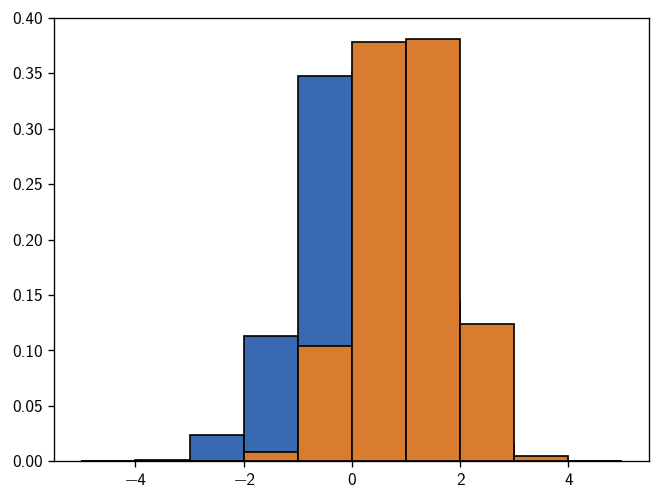

In [22]:
# Compute histograms using NumPy
px, *_ = p(x, range=(-5, 5), bins=10)
py, e, emids = p(y, range=(-5, 5), bins=10)
de = e[1] - e[0]
plt.bar(emids, px, width=de, edgecolor="k")
plt.bar(emids, py, width=de, edgecolor="k")

In [23]:
%timeit _ = p(x, range=(-5, 5), bins=10)

123 μs ± 491 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


<BarContainer object of 10 artists>

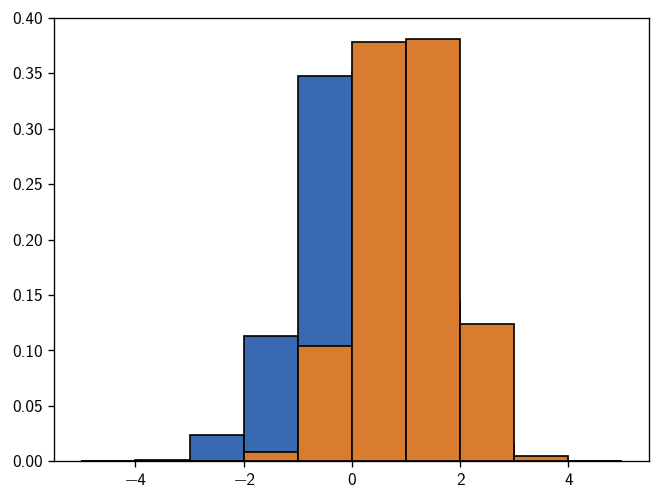

In [24]:
# Compute histograms using cython functions
edges = np.linspace(-5, 5, 11)
cpx = c_histogram(x, edges)
cpx = np.true_divide(cpx, np.sum(cpx))
cpy = c_histogram(y, edges)
cpy = np.true_divide(cpy, np.sum(cpy))
emids = (edges[1:] + edges[:-1]) / 2
de = edges[1] - edges[0]
plt.bar(emids, cpx, width=de, edgecolor="k")
plt.bar(emids, cpy, width=de, edgecolor="k")

In [25]:
%timeit _ = c_histogram(x, edges)

16.5 μs ± 2.23 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Text(0, 0.5, '$y$')

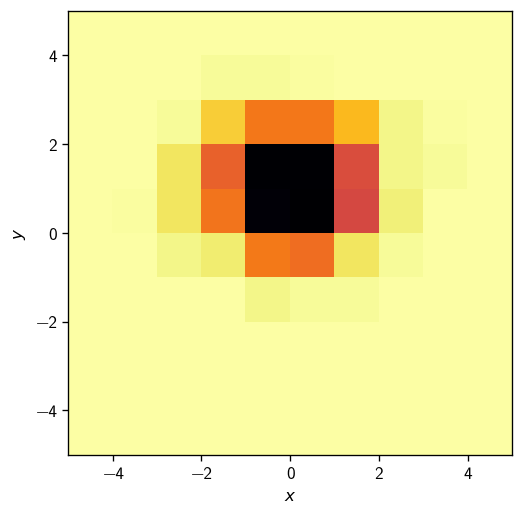

In [26]:
# Compute 2D histogram using NumPy
pxy_counts, ex, ey = p_joint(x, y, range=[(-5, 5), (-5, 5)], bins=[10, 10], weights=None) 
pxy = np.true_divide(pxy_counts, np.sum(pxy_counts))
plt.imshow(pxy.T, extent=[ex[0], ex[-1], ey[0], ey[-1]], cmap=mpl.cm.inferno_r, origin="lower")
plt.xlabel("$x$")
plt.ylabel("$y$")

In [27]:
%timeit _ = p_joint(x, y, range=[(-5, 5), (-5, 5)], bins=[10, 10])

199 μs ± 19.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Text(0, 0.5, '$y$')

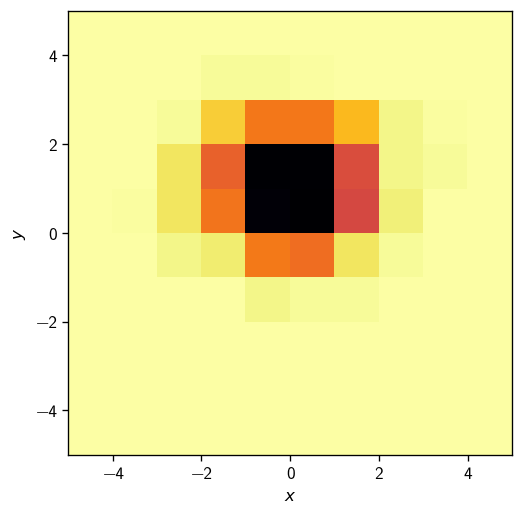

In [28]:
# Compute 2D histogram using cython functions
edges = np.linspace(-5, 5, 11)
cpxy = c_histogramdd(xy, edges) 
cpxy = np.true_divide(cpxy, np.sum(cpxy))
plt.imshow(
    cpxy.reshape(10, 10).T,
    extent=[edges[0],
    edges[-1], edges[0], edges[-1]],
    cmap=mpl.cm.inferno_r, origin="lower"
)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [29]:
%timeit _ = c_histogramdd(xy, edges)

55.4 μs ± 66.3 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Text(0, 0.5, '$y$')

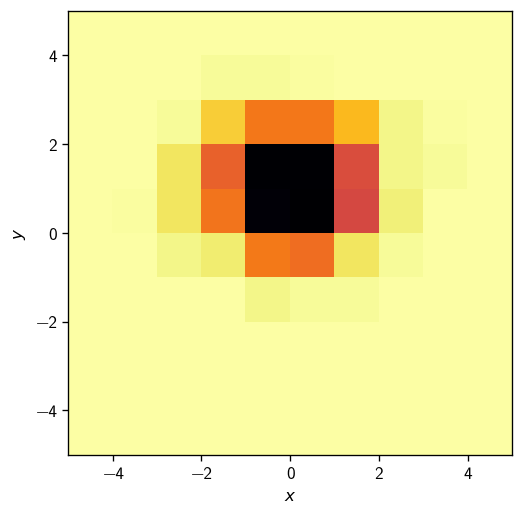

In [30]:
# Compute joint histogram using cython functions (joint)
edges = np.linspace(-5, 5, 11)
cpxy_joint = c_histogramdd_joint(x_, y_, edges) 
cpxy_joint = np.true_divide(cpxy_joint, np.sum(cpxy_joint))
plt.imshow(
    cpxy_joint.reshape(10, 10).T,
    extent=[edges[0],
    edges[-1], edges[0], edges[-1]],
    cmap=mpl.cm.inferno_r, origin="lower"
)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [31]:
%timeit _ = c_histogramdd_joint(x_, y_, edges)

44.3 μs ± 93 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Text(0, 0.5, '$y$')

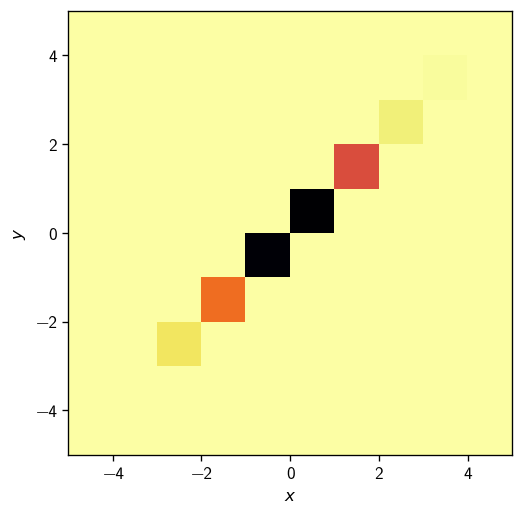

In [32]:
pxx, ex, ey = p_joint(x, x, range=[(-5, 5), (-5, 5)], bins=[10, 10]) 
plt.imshow(pxx.T, extent=[ex[0], ex[-1], ey[0], ey[-1]], cmap=mpl.cm.inferno_r, origin="lower")
plt.xlabel("$x$")
plt.ylabel("$y$")

##### Checks

In [33]:
cpx_from_joint = np.asarray(compute_marginal_x(cpxy_joint))
cpy_from_joint = np.asarray(compute_marginal_y(cpxy_joint))

In [34]:
print(np.allclose(px, cpx, rtol=1e-18))
print(np.allclose(py, cpy, rtol=1e-18))
print(np.allclose(pxy, cpxy.reshape(10, 10), rtol=1e-18))
print(np.allclose(pxy, cpxy_joint.reshape(10, 10), rtol=1e-18))
print(np.allclose(px, cpx_from_joint, rtol=1e-18))
print(np.allclose(py, cpy_from_joint, rtol=1e-18))

True
True
True
True
True
True


In [35]:
%timeit _ = compute_marginal_x(cpxy_joint)

1.19 μs ± 4.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [36]:
for row in pxy:
    print(*(f"{element:4.2f}" for element in row), sep="  ")

0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.01  0.01  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.01  0.04  0.05  0.02  0.00  0.00
0.00  0.00  0.00  0.00  0.04  0.13  0.13  0.04  0.00  0.00
0.00  0.00  0.00  0.00  0.04  0.13  0.13  0.04  0.00  0.00
0.00  0.00  0.00  0.00  0.01  0.06  0.06  0.02  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.01  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00
0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00


##### Entropy

In [39]:
scipy.stats.entropy(px)

np.float64(1.4402743645804708)

In [40]:
min(scipy.stats.entropy(px), scipy.stats.entropy(py))

np.float64(1.2947444215733235)

In [41]:
shannon_entropy(px)

np.float64(1.4402743645804712)

In [42]:
min(shannon_entropy(px), shannon_entropy(py))

np.float64(1.2947444215733235)

In [43]:
c_shannon_entropy(px)

1.4402743645804712

In [44]:
%timeit scipy.stats.entropy(px)

307 μs ± 21.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [45]:
%timeit shannon_entropy(px)

4.65 μs ± 37.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [46]:
%timeit c_shannon_entropy(px)

341 ns ± 2.35 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


##### Mutual information

In [47]:
# Sklearn (needs unnormalised bin counts)
mutual_info_score(labels_true=None, labels_pred=None, contingency=pxy_counts)

0.01306015560052112

In [48]:
mutual_information(px, py, pxy, norm=False)

np.float64(0.013060155600520101)

In [49]:
mutual_information(px, py, pxy, norm=True)

np.float64(0.010087052998961682)

In [50]:
mutual_information(py, px, pxy.T, norm=False)

np.float64(0.013060155600520101)

In [51]:
mutual_information(py, px, pxy.T, norm=True)

np.float64(0.010087052998961682)

In [52]:
mutual_information(px, px, pxx)

np.float64(1.0)

In [53]:
c_norm_mutual_information(px, py, np.asarray(pxy, order="c"))

0.01008705299896168

In [54]:
c_norm_mutual_information(cpx, cpy, np.asarray(cpxy.reshape(10, 10), order="c"))

0.010087052998962842

In [55]:
c_norm_mutual_information(cpx, cpy, cpxy_joint)

0.010087052998962842

In [56]:
c_norm_mutual_information(px, px, np.asarray(pxx, order="c"))

1.0

In [57]:
%timeit mutual_information(px, py, pxy, norm=True)

67 μs ± 286 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [58]:
%timeit c_norm_mutual_information(px, py, pxy)

1.45 μs ± 199 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


#### Coin flip

In [59]:
coin_px = np.array([0.5, 0.5])
coin_py = np.array([0.5, 0.5])
coin_pxy_independent = np.array([[0.25, 0.25], [0.25, 0.25]])
coin_pxy_dependent = np.array([[0.5, 0.], [0., 0.5]])

In [60]:
mutual_information(coin_px, coin_py, coin_pxy_independent)

np.float64(0.0)

In [61]:
mutual_information(coin_px, coin_py, coin_pxy_dependent)

np.float64(1.0)

In [62]:
c_norm_mutual_information(coin_px, coin_py, coin_pxy_independent)

0.0

In [63]:
c_norm_mutual_information(coin_px, coin_py, coin_pxy_dependent)

1.0

## Calculation

### Feature preparation

For the analysis we need our features in form of 2D NumPy array of shape (#frames, #features). We also need a list of feature IDs of length #features. The Cython functions need the feature arrays in C-order and of type float but we can let `prepare_feature_list` take care of that later.

In [24]:
features = np.load("../../../data/dihedral_angle_features.npy")
with open("../../../data/dihedral_angle_feature_ids.dat") as fp:
    feature_ids = fp.read().splitlines()

In [25]:
features.shape

(2000, 493)

In [26]:
len(feature_ids)

493

In [27]:
feature_ids[:10]

['phi-CYS256',
 'phi-PRO257',
 'phi-TRP258',
 'phi-GLU259',
 'phi-TRP260',
 'phi-THR261',
 'phi-PHE262',
 'phi-PHE263',
 'phi-GLN264',
 'phi-GLY265']

In [28]:
# Shortened feature IDs without residue name for easier indexing
short_feature_ids = [f"{fid.split('-')[0]}-{fid[-3:]}" for fid in feature_ids]

### Validation

In [39]:
fx = features[:, feature_ids.index(f"phi-MET270")]
fy = features[:, feature_ids.index(f"psi-MET270")]

px, *_ = p(fx)
py, *_ = p(fy)
pxy, ex, ey = p_joint(fx, fy)

Text(0.5, 0, 'angle / rad')

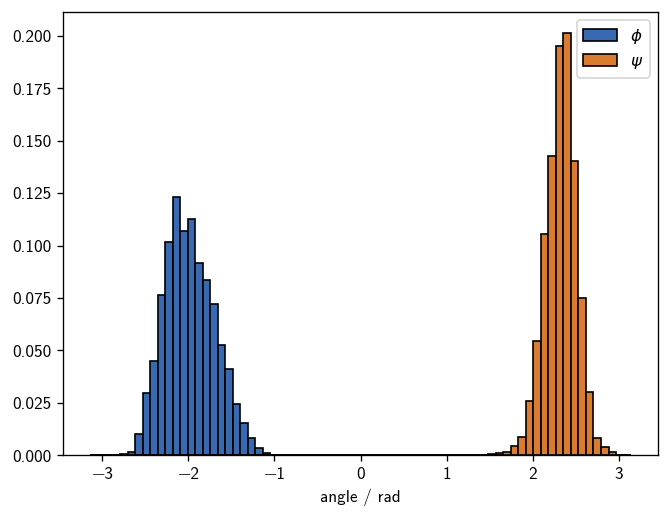

In [40]:
emids = (ex[1:] + ex[:-1]) / 2
de = ex[1] - ex[0]
plt.bar(emids, px, width=de, edgecolor="k")
plt.bar(emids, py, width=de, edgecolor="k")
plt.legend(["$\phi$", "$\psi$"])
plt.xlabel("angle / rad")

Text(0, 0.5, '$\\psi$')

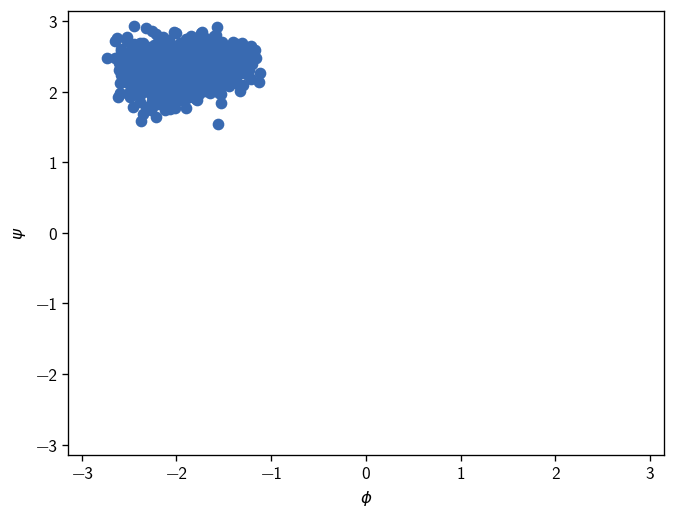

In [41]:
plt.scatter(fx, fy)
plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

Text(0, 0.5, '$\\psi$')

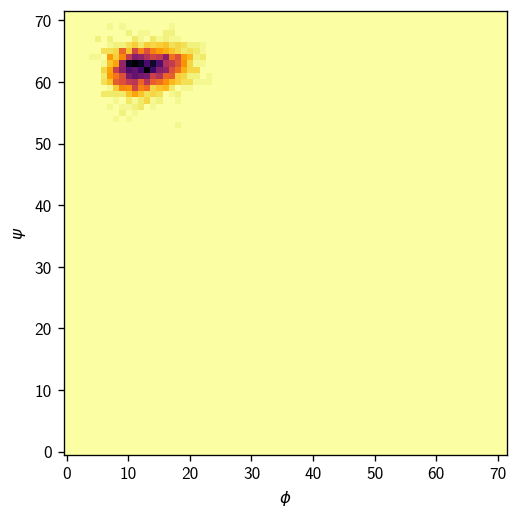

In [42]:
plt.imshow(pxy.T, cmap=mpl.cm.inferno_r, origin="lower")
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

/tmp/ipykernel_171061/1166145298.py:3: RuntimeWarning: divide by zero encountered in log
  pxy_ = -np.log(pxy_)


Text(0, 0.5, '$\\psi$')

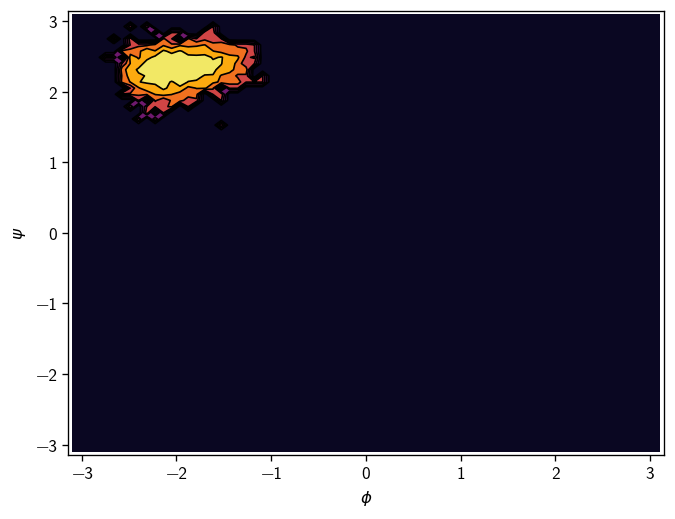

In [44]:
pxy_ = pxy.T
# pxy_[pxy_ == 0] = np.nan
pxy_ = -np.log(pxy_)
pxy_ -= np.min(pxy_)
pxy_[pxy_ > 8] = 8

plt.contourf(
    *np.meshgrid(emids, emids), pxy_, cmap=mpl.cm.inferno_r,
    levels=range(9)
)
plt.contour(
    *np.meshgrid(emids, emids), pxy_, colors="k",
    linewidths=1,
    levels=range(9)
)
plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

In [45]:
fx = features[:, feature_ids.index(f"phi-MET270")]
fy = features[:, feature_ids.index(f"psi-MET270")]

fxy = np.asarray(np.vstack([fx, fy]).T, order="c", dtype=np.float64)

edges = np.linspace(-np.pi, np.pi, 73)
pxy = c_histogramdd(fxy, edges)

/tmp/ipykernel_171061/439896059.py:3: RuntimeWarning: divide by zero encountered in log
  pxy_ = -np.log(pxy_)


Text(0, 0.5, '$\\psi$')

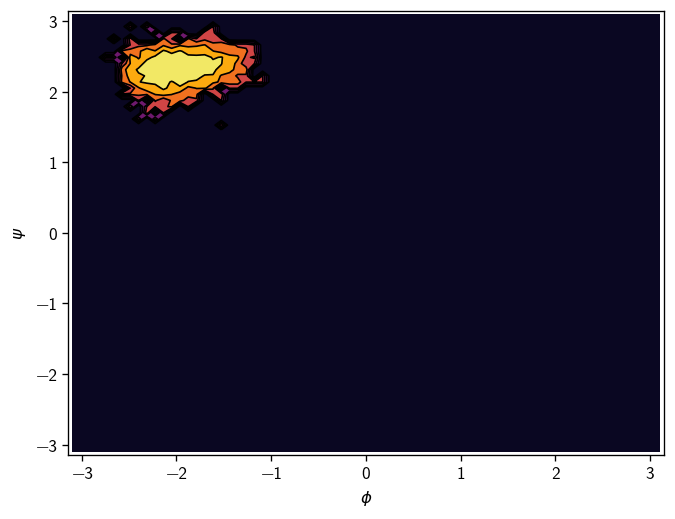

In [46]:
pxy_ = np.array(pxy).reshape(72, 72).T
# pxy_[pxy_ == 0] = np.nan
pxy_ = -np.log(pxy_)
pxy_ -= np.min(pxy_)
pxy_[pxy_ > 8] = 8

plt.contourf(
    *np.meshgrid(emids, emids), pxy_, cmap=mpl.cm.inferno_r,
    levels=range(9)
)
plt.contour(
    *np.meshgrid(emids, emids), pxy_, colors="k",
    linewidths=1,
    levels=range(9)
)
plt.xlim((-np.pi, np.pi))
plt.ylim((-np.pi, np.pi))
plt.xlabel("$\phi$")
plt.ylabel("$\psi$")

### Mutual information

#### Single features only (a)

In [29]:
feature_list, feature_list_ids = prepare_feature_list(
    features,
    [
        (("phi",), "phi"),
        (("psi",), "psi"),
        (("chi1",), "chi1"),
        (("chi2",), "chi2"),
        (("chi3",), "chi3"),
        (("chi4",), "chi4"),
    ],
    feature_ids=short_feature_ids,
)

  0%|          | 0/125 [00:00<?, ?it/s]

In [31]:
# Compute mutual information (cythonized alternative below)

n_features = len(feature_list)
nmi_matrix = np.eye(n_features)
edges = np.linspace(-np.pi, np.pi, 73, dtype=np.float64)

for xi, fx in enumerate(tqdm(feature_list)):
    for yi, fy in enumerate(feature_list[xi + 1:], xi + 1):

        # NumPy only
        # px, *_ = p(fx.T[0])
        # py, *_ = p(fy.T[0])
        # pxy, *_ = p_joint(fx.T[0], fy.T[0])

        pxy = c_histogramdd_joint(fx, fy, edges)
        c_norm_pxy_fixed(pxy, fx.shape[0])
        px = compute_marginal_x(pxy)
        py = compute_marginal_y(pxy)

        nmi_matrix[xi, yi] = c_norm_mutual_information(px, py, pxy)

  0%|          | 0/487 [00:00<?, ?it/s]

In [ ]:
# No further speedup though (bottleneck is conversion of features to memoryviews)
nmi_matrix = np.asarray(compute_nmi_matrix_from_feature_list(feature_list, save_checkpoints=False))

In [32]:
nmi_matrix.max()

np.float64(1.0)

In [33]:
print(nmi_matrix[nmi_matrix < 1].max())
print(nmi_matrix[nmi_matrix > 0].min())

0.48092084932974294
0.02637190359925878


In [34]:
nmi_matrix

array([[1.        , 0.06801104, 0.08271966, ..., 0.06636276, 0.07051802,
        0.09219896],
       [0.        , 1.        , 0.08502908, ..., 0.0799064 , 0.08423423,
        0.09673524],
       [0.        , 0.        , 1.        , ..., 0.04850443, 0.0649494 ,
        0.08671834],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.08556236,
        0.09700362],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.09220234],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], shape=(487, 487))

In [ ]:
G = nmi_matrix_to_graph(nmi_matrix, feature_list_ids)

In [ ]:
networkx.readwrite.gml.write_gml(G, "phi_psi_chi.gml")

#### Backbone as 2D feature (b)

In [ ]:
feature_list, feature_list_ids = prepare_feature_list(
    [
        (("phi", "psi"), "bb"),
        (("chi1",), "chi1")
    ]
)

  0%|          | 0/126 [00:00<?, ?it/s]

In [ ]:
nmi_matrix = np.asarray(compute_nmi_matrix_from_feature_list(feature_list, save_checkpoints=False))

In [ ]:
nmi_matrix.max()

1.0

In [ ]:
print(nmi_matrix[nmi_matrix < 1].max())
print(nmi_matrix[nmi_matrix > 0].min())

0.2537015136839204
0.0001850924089682497


In [ ]:
G = nmi_matrix_to_graph(nmi_matrix, feature_list_ids)

In [ ]:
networkx.readwrite.gml.write_gml(G, "bb_chi1.gml")

#### All $\chi$-angles (c)

In [ ]:
feature_list, feature_list_ids = prepare_feature_list(
    features,
    [
        (("phi", "psi"), "bb"),
        (("chi1",), "chi1"),
        (("chi2",), "chi2"),
        (("chi3",), "chi3"),
        (("chi4",), "chi4")
    ],
    feature_ids=short_feature_ids,
)

TypeError: prepare_feature_list() missing 1 required positional argument: 'feature_definitions'

In [ ]:
nmi_matrix = np.asarray(compute_nmi_matrix_from_feature_list(feature_list, save_checkpoints=False))

In [ ]:
nmi_matrix.max()

1.0

In [ ]:
print(nmi_matrix[nmi_matrix < 1].max())
print(nmi_matrix[nmi_matrix > 0].min())

0.4442034791237605
0.0001850924089682497


In [ ]:
G = nmi_matrix_to_graph(nmi_matrix, feature_list_ids)

In [ ]:
networkx.readwrite.gml.write_gml(G, "bb_chi.gml")

#### Plots

In [ ]:
G = networkx.readwrite.gml.read_gml("bb_chi.gml")
nmi_matrix = graph_to_nmi_matrix(G, feature_list_ids)

In [ ]:
tril = np.tril_indices_from(nmi_matrix)
nmi_matrix[tril] = nmi_matrix.T[tril]

In [ ]:
for i, (a, b, d) in enumerate(G.edges(data=True)):
    print(a, b, d["nmi"])

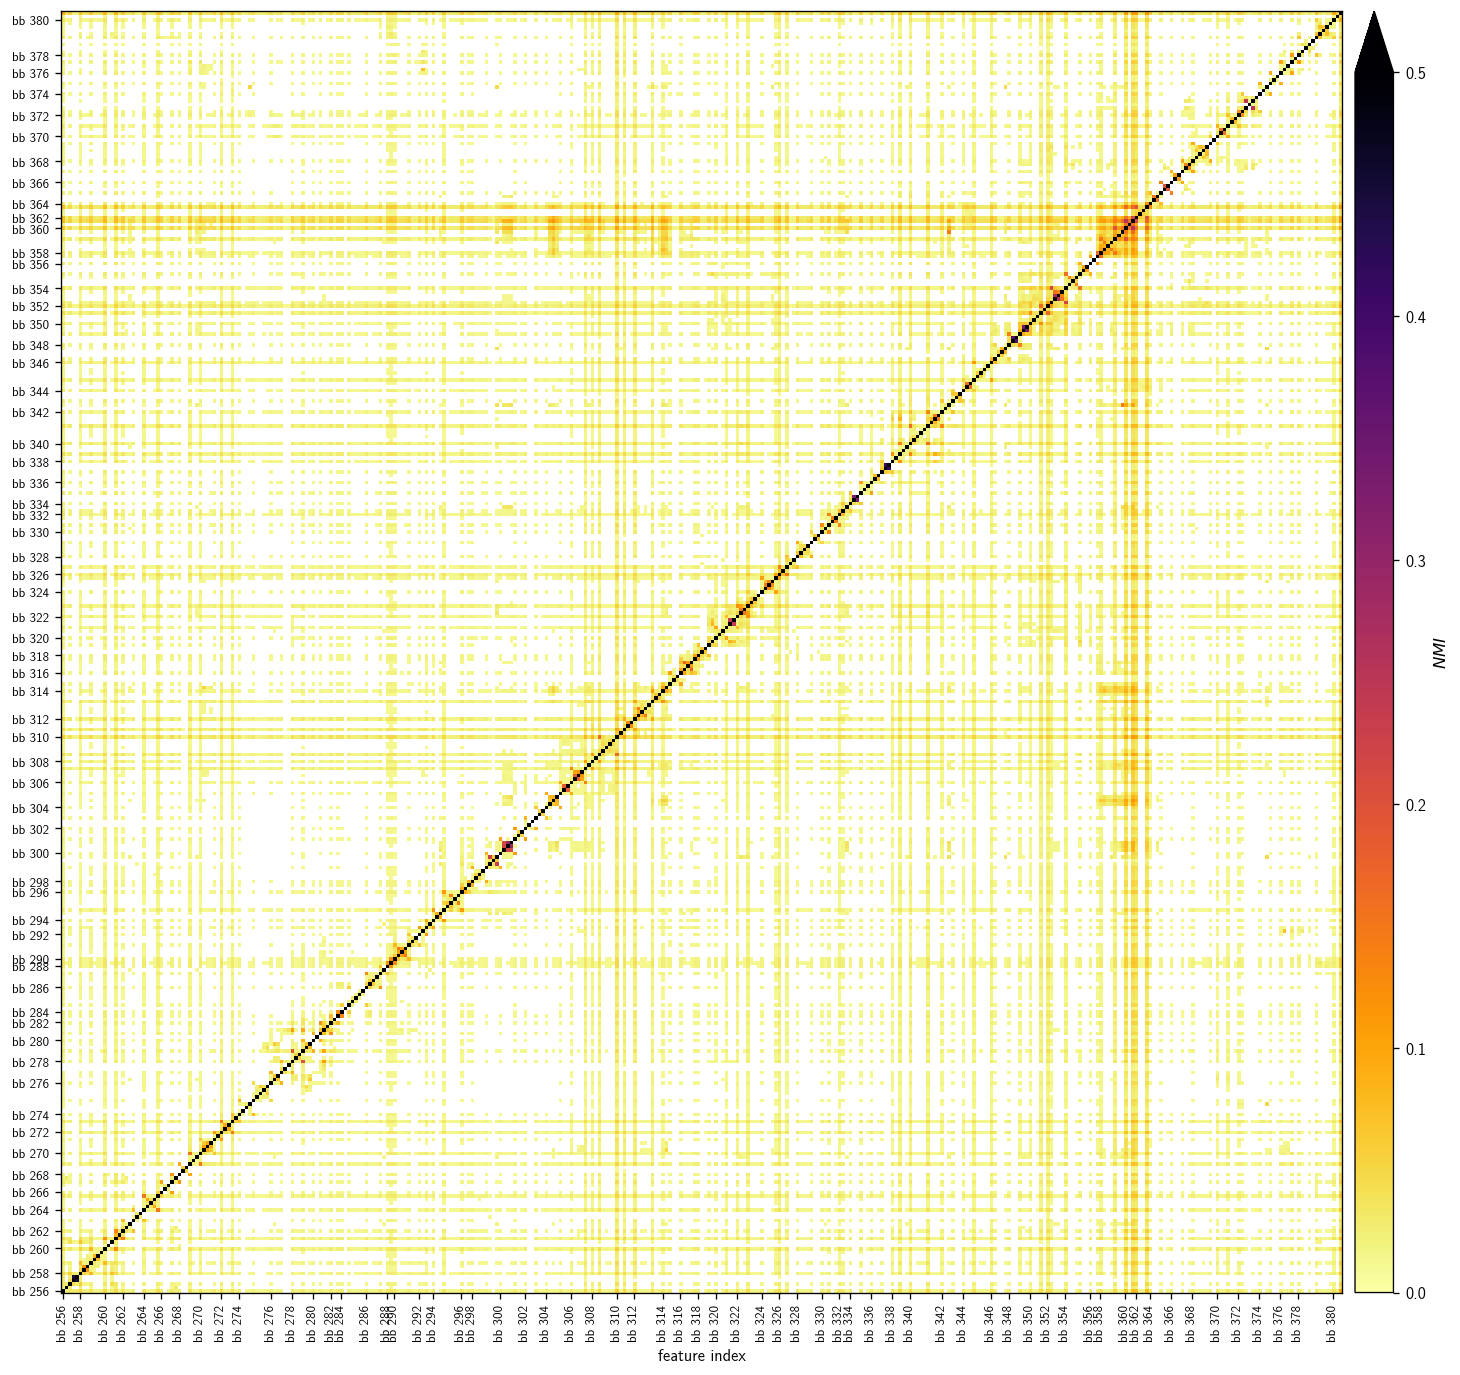

In [ ]:
thresholds = (0.01, 1.)
_nmi_matrix = np.copy(nmi_matrix)
_nmi_matrix[_nmi_matrix < thresholds[0]] = np.nan
_nmi_matrix[_nmi_matrix > thresholds[1]] = np.nan

fig, ax = plt.subplots(figsize=(12, 12))

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="3%", pad="1%")

matrix_plot = ax.imshow(_nmi_matrix, origin="lower", cmap=mpl.cm.inferno_r, vmin=0, vmax=0.5)
cbar = fig.colorbar(matrix_plot, ax=ax, cax=cax, extend="max", label="$NMI$")
ticks, ticklabels = zip(*[
    (index, format_id(fid))
    for index, fid in enumerate(feature_list_ids)
    if fid.startswith("bb")
][::2])
ax.set(**{
    "xticks": ticks,
    "yticks": ticks,
    "xlabel": "feature index",
})
_ = ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
_ = ax.set_yticklabels(ticklabels, rotation=0, fontsize=8)

fig.tight_layout(pad=0.1)
fig.savefig("bb_chi_matrix.png", facecolor="white", edgecolor='none')

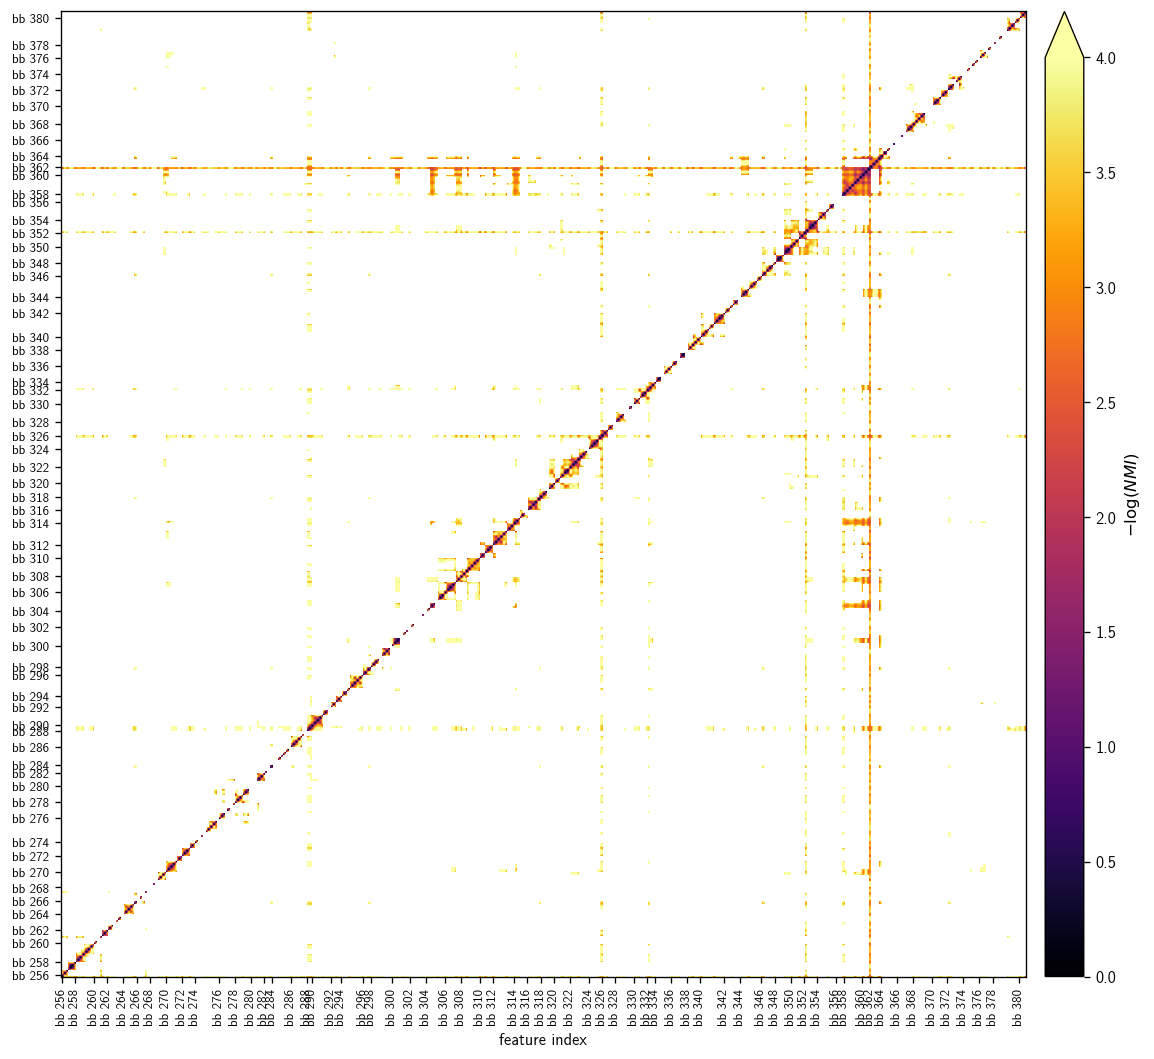

In [ ]:
thresholds = (0.01, 1.)
_nmi_matrix = np.copy(nmi_matrix)
_nmi_matrix[_nmi_matrix < thresholds[0]] = np.nan
_nmi_matrix[_nmi_matrix > thresholds[1]] = np.nan

_nmi_matrix = -np.log(_nmi_matrix)

fig, ax = plt.subplots(figsize=(11, 11))

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="4%", pad="2%")

matrix_plot = ax.imshow(_nmi_matrix, origin="lower", cmap=mpl.cm.inferno, vmin=0, vmax=4)
cbar = fig.colorbar(matrix_plot, ax=ax, cax=cax, extend="max", label="$-\mathrm{log}(NMI)$")
ticks, ticklabels = zip(*[
    (index, format_id(fid))
    for index, fid in enumerate(feature_list_ids)
    if fid.startswith("bb")
][::2])
ax.set(**{
    "xticks": ticks,
    "yticks": ticks,
    "xlabel": "feature index",
})
_ = ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
_ = ax.set_yticklabels(ticklabels, rotation=0, fontsize=8)

#### Projection

Condense matrix to residues-wise values.

In [ ]:
res_range = range(256, 382)

res_array = np.array([
    int(fid.rsplit("_", 1)[-1])
    for fid in feature_list_ids
])

tmp_p = []
for res in res_range:
    tmp_p.append(np.where(res_array == res, 1, 0))

pl = np.vstack(tmp_p)

In [ ]:
projected_nmi_matrix = pl @ nmi_matrix @ pl.T

In [555]:
projected_nmi_matrix_c.shape

(126, 126)

In [ ]:
projected_nmi_matrix.max()

6.111011931194026

In [ ]:
print(projected_nmi_matrix[projected_nmi_matrix < 1].max())
print(projected_nmi_matrix[projected_nmi_matrix > 0].min())

0.7496826221976051
0.011854276827236164


##### Plots

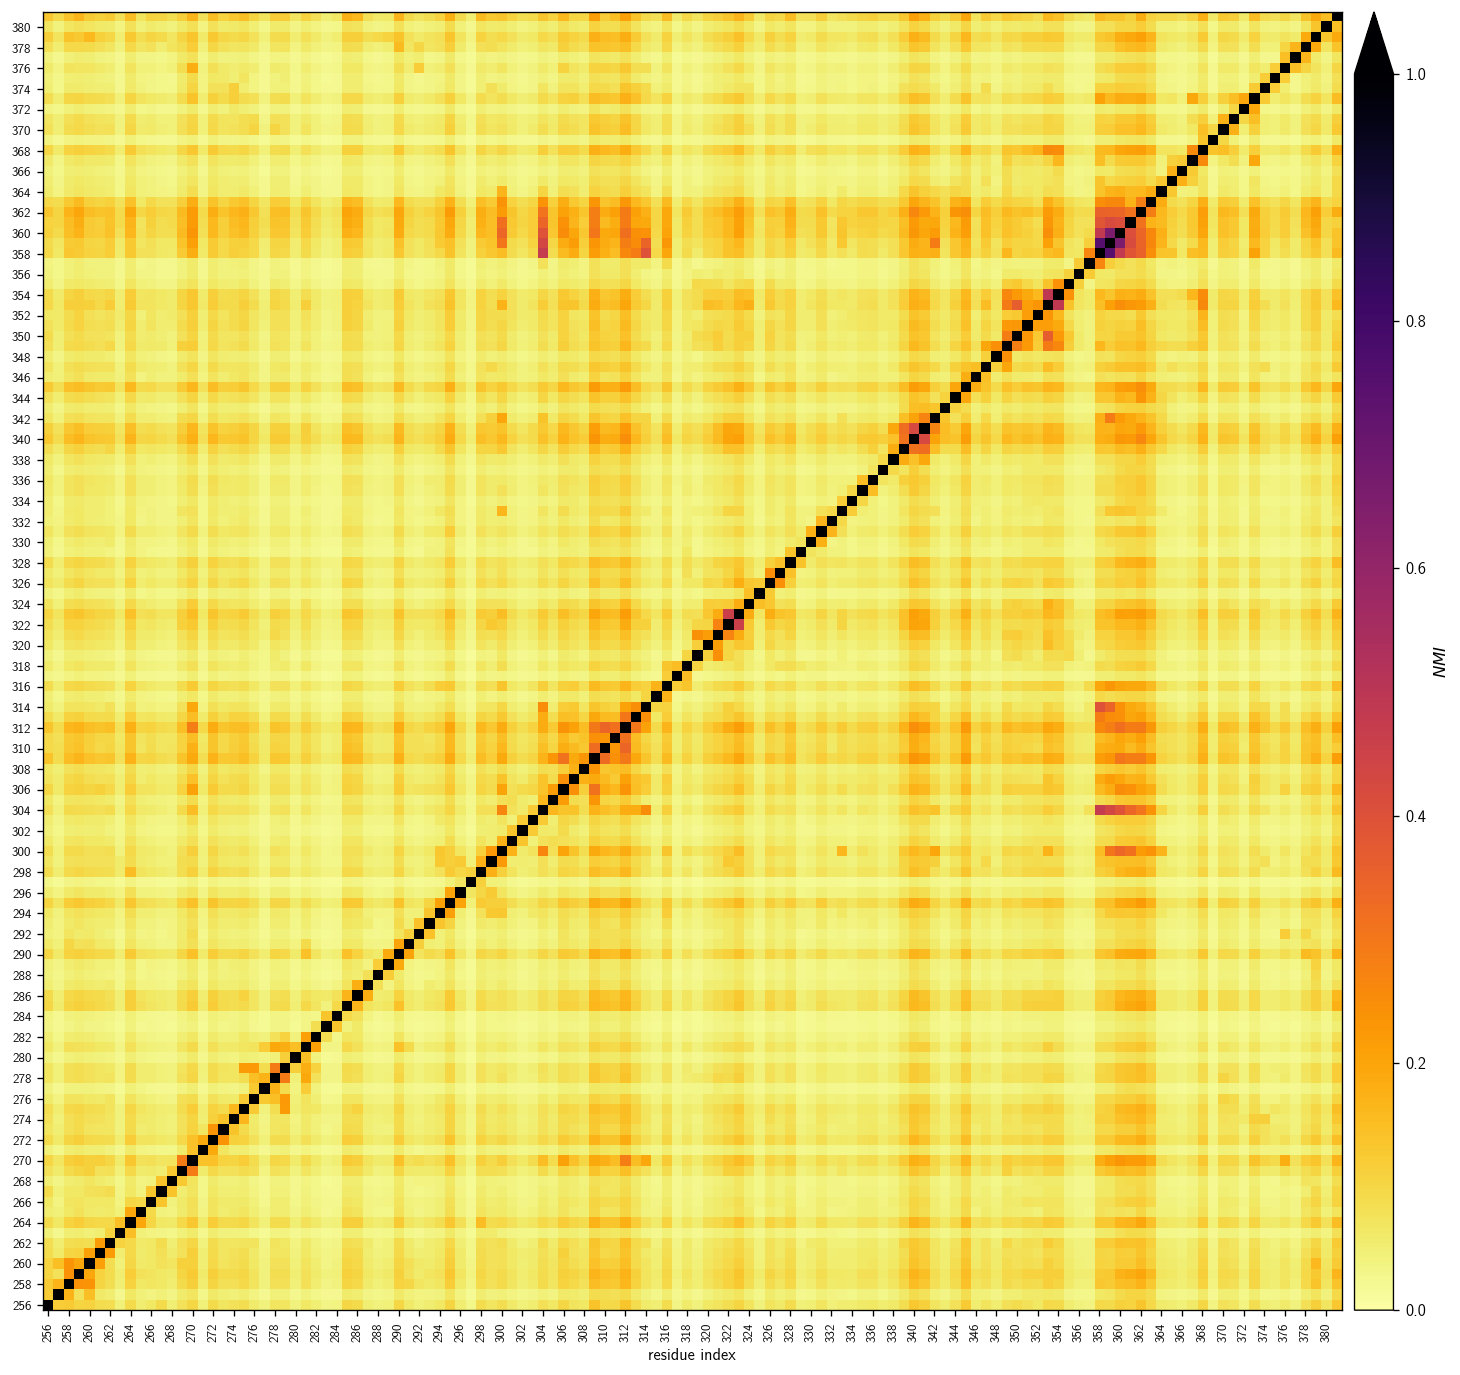

In [ ]:
thresholds = (0.01, 8)
_nmi_matrix = np.copy(projected_nmi_matrix)
_nmi_matrix[_nmi_matrix < thresholds[0]] = np.nan
_nmi_matrix[_nmi_matrix > thresholds[1]] = np.nan

fig, ax = plt.subplots(figsize=(12, 12))

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("right", size="3%", pad="1%")

matrix_plot = ax.imshow(_nmi_matrix, origin="lower", cmap=mpl.cm.inferno_r, vmin=0, vmax=1)
cbar = fig.colorbar(matrix_plot, ax=ax, cax=cax, extend="max", label="$NMI$")
ticks, ticklabels = zip(*[
    (index, res)
    for index, res in enumerate(res_range)
][::2])
ax.set(**{
    "xticks": ticks,
    "yticks": ticks,
    "xlabel": "residue index",
})
_ = ax.set_xticklabels(ticklabels, rotation=90, fontsize=8)
_ = ax.set_yticklabels(ticklabels, rotation=0, fontsize=8)

fig.tight_layout(pad=0.1)
fig.savefig("bb_chi_projected_matrix.png", facecolor="white", edgecolor='none')